In [6]:
from pathlib import Path
import xarray as xr
import scipy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [7]:
data_path = Path("../data")
ds = xr.open_dataset(data_path/"data.nc")

In [8]:
ds

<xarray.Dataset> Size: 84MB
Dimensions:    (time: 41623, component: 500)
Coordinates:
  * time       (time) float64 333kB 0.0 0.03301 0.06602 ... 1.374e+03 1.374e+03
  * component  (component) int32 2kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
Data variables:
    response   (time, component) float32 83MB ...
    regressor  (time) float64 333kB ...
Attributes:
    fs:       30.292913412780123

In [9]:
ds.response.shape

(41623, 500)

In [10]:
ds.regressor.shape

(41623,)

In [11]:
X = ds.regressor.values

max_lag = 50 #range of lag
n = len(X)
X_lagged = np.zeros((n, max_lag))
for lag in range(max_lag):
    X_lagged[lag:, lag] = X[:n-lag]

In [12]:
X_lagged.shape

(41623, 50)

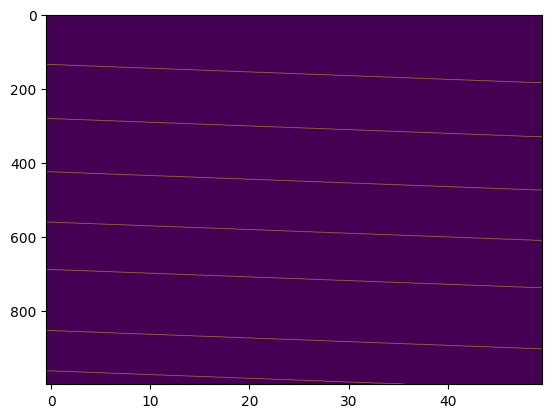

In [13]:
plt.imshow(X_lagged[:1000, :], aspect="auto")

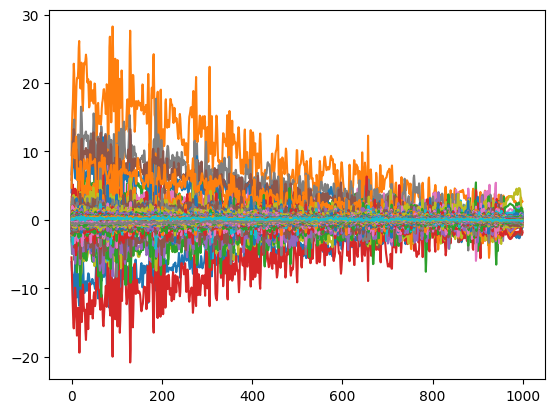

In [14]:
y = ds.response.values
plt.plot(y[:1000]);

In [15]:
intercept_col = np.ones((X.shape[0],1))
intercept_col

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(41623, 1))

In [16]:
X_lagged = np.hstack((intercept_col,X_lagged))
X_lagged.shape

(41623, 51)

In [19]:
b = np.linalg.solve(X_lagged.T @ X_lagged, X_lagged.T @ y)

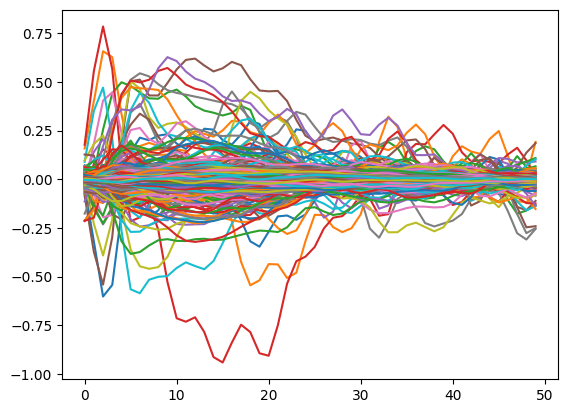

In [20]:
plt.plot(b[1:]);

In [28]:
# %%timeit
lam = 0.1 # you can get the best value for lambda from cross-validation
b_ridge = np.linalg.solve(X_lagged.T @ X_lagged + lam * np.eye(X_lagged.shape[1]), X_lagged.T @ y)

In [29]:
b_ridge.shape

(51, 500)

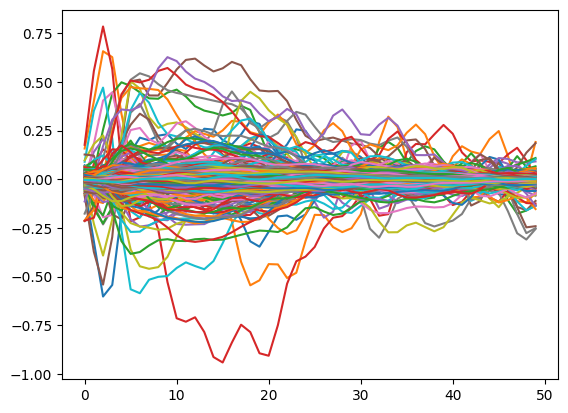

In [30]:
plt.plot(b_ridge[1:]);

In [31]:
X.shape

(41623,)

In [32]:
b_ridge.shape

(51, 500)

In [33]:
y_pred = np.zeros(y.shape)
for i in range(y.shape[1]):
    y_pred[:, i] = np.convolve(X, b_ridge[1:, i], mode="full")[:n] + b_ridge[0, i]


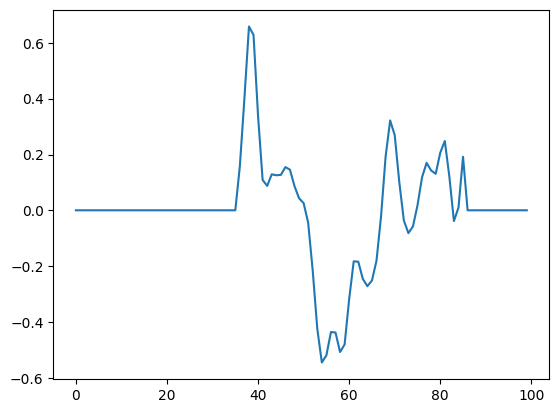

In [49]:
# plt.plot(y[:,1])
plt.plot(y_pred[100:200,1])

In [ ]:
y_z = (y - y.mean(axis=0)) / y.std(axis=0)
yp_z = (y_pred - y_pred.mean(axis=0)) / y_pred.std(axis=0)
r = (y_z * yp_z).mean(axis=0)
r


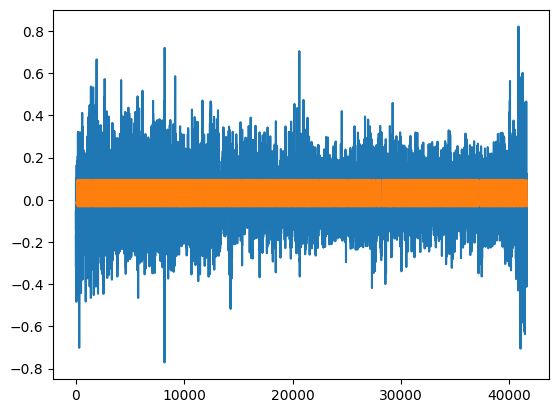

In [43]:
idx = np.argmax(r)
plt.plot(y[:, idx])
plt.plot(y_pred[:, idx])

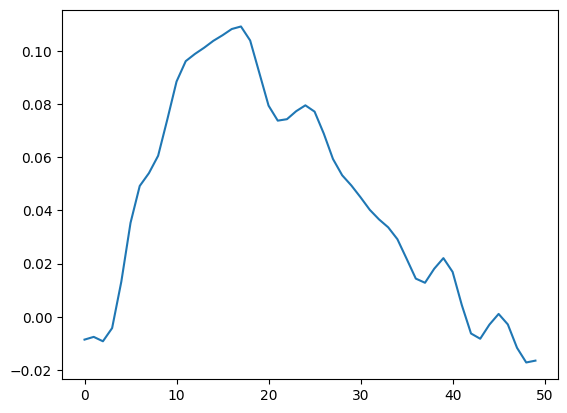

In [44]:
plt.plot(b_ridge[1:, idx])